In [1]:
from google.colab import drive

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np

In [4]:
from scipy.stats import norm
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
!ls "drive/MyDrive/Colab Notebooks/Youtube Practise/Python for Data Science Course"

ab_test_click_data.csv	CaseStudy_AB_testing.ipynb


In [6]:
df=pd.read_csv("drive/MyDrive/Colab Notebooks/Youtube Practise/Python for Data Science Course/ab_test_click_data.csv")

In [7]:
df.head()

,user_id,click,group,timestamp
0,1,1,exp,2024-01-01 00:00:00
1,2,0,exp,2024-01-01 00:01:00
2,3,1,exp,2024-01-01 00:02:00
3,4,0,exp,2024-01-01 00:03:00
4,5,1,exp,2024-01-01 00:04:00


In [8]:
df.describe()

,user_id,click
count,20000.000000,20000.000000
mean,10000.500000,0.405250
std,5773.647028,0.490953
min,1.000000,0.000000
25%,5000.750000,0.000000
50%,10000.500000,0.000000
75%,15000.250000,1.000000
max,20000.000000,1.000000


In [9]:
df.groupby("click").sum("click")

,user_id
click,
0,139615577
1,60394423


In [10]:
palette={0:'yellow',1:'black'}

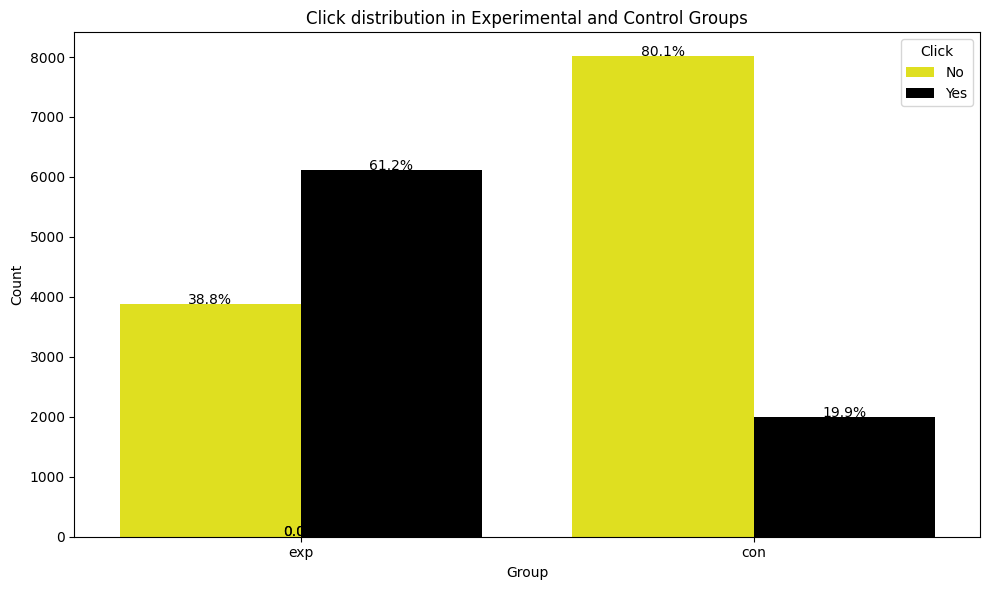

In [11]:
plt.figure(figsize=(10,6))
ax=sns.countplot(x='group',hue='click',data=df,palette=palette)
plt.title('Click distribution in Experimental and Control Groups')
plt.xlabel('Group')
plt.ylabel('Count')
plt.legend(title="Click",labels=['No','Yes'])

group_counts=df.groupby(['group']).size()
group_click_counts=df.groupby(['group','click']).size().reset_index(name='count')

for p in ax.patches:
  height=p.get_height()
  group='exp' if p.get_x() else 'con'
  click=1 if p.get_x() % 1 > 0.5 else 0
  total=group_counts.loc[group]
  percentage=100*height / total
  ax.text(p.get_x()+p.get_width()/2.,height+5,f'{percentage:.1f}%',ha="center",color="black",fontsize=10)
plt.tight_layout()
plt.show()

In [12]:
#Parameters of the model from Power Analysis

In [13]:
alpha=0.05
print("Alpha significance level is:",alpha)
delta=0.1
print("Delta minimum detectable effect is:",delta)

Alpha significance level is: 0.05
Delta minimum detectable effect is: 0.1


In [14]:
#Calculating total number of clicks per group by summing clicks
X_con=df.groupby("group")["click"].sum().loc["con"]
X_exp=df.groupby("group")["click"].sum().loc["exp"]

print(df.groupby("group")["click"].sum())
print("Number of clicks in control:",X_con)
print("Number of clicks in experimental:",X_exp)

group
con    1989
exp    6116
Name: click, dtype: int64
Number of clicks in control: 1989
Number of clicks in experimental: 6116


In [15]:
N_exp = 10000
N_con = 10000

In [16]:
#Calculating Poolde Estimates for clicks per group
p_con_hat=X_con/N_con
p_exp_hat=X_exp/N_exp


print("Click probability in Control Group:",p_con_hat)
print("Click probability in Experimental Group:",p_exp_hat)

Click probability in Control Group: 0.1989
Click probability in Experimental Group: 0.6116


In [17]:
p_pooled_hat=(X_con+X_exp)/(N_con+N_exp)

In [19]:
#Calculating the Pooled Variance

In [21]:
pooled_variance=p_pooled_hat*(1-p_pooled_hat)*(1/N_con+1/N_exp)

In [22]:
print("p_pooled_hat:",p_pooled_hat)
print("pooled_variance:",pooled_variance)

p_pooled_hat: 0.40525
pooled_variance: 4.82044875e-05


In [23]:
#Calculating Standard Error and Test Statistics

In [24]:
SE=np.sqrt(pooled_variance)
print("Standard Error:",SE)

Test_stat=(p_con_hat - p_exp_hat)/SE
print("Test Statistics for 2-sample Z-test is:",Test_stat)

Z_crit=norm.ppf(1-alpha/2)
print("Z critical value from Standard Normal Distribution:",Z_crit)



Standard Error: 0.006942945160376826
Test Statistics for 2-sample Z-test is: -59.44163326469381
Z critical value from Standard Normal Distribution: 1.959963984540054


In [26]:
#Calculating p_values of the Z-Test

In [27]:
p_value=2*norm.sf(abs(Test_stat))
def is_statistical_significance(p_value,aplha):
  print(f"P-value of the 2-sample Z-test:{round(p_value,3)}")
  if p_value < alpha:
    print("ok")
  else:
    print("nok")

In [31]:
is_statistical_significance(p_value,alpha)

P-value of the 2-sample Z-test:0.0
ok


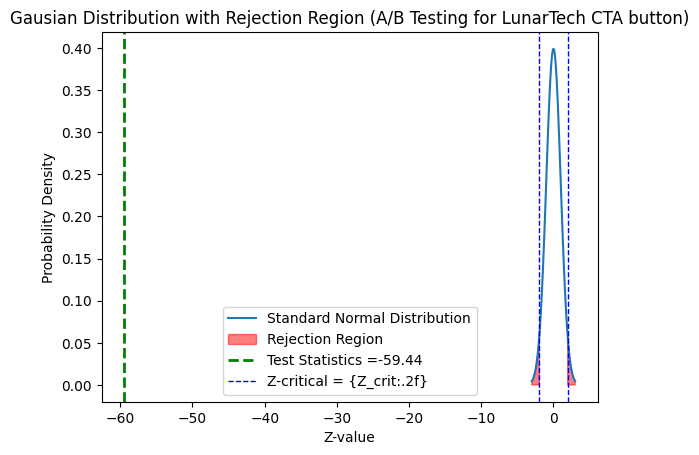

In [34]:
#Parameters for standard normal distribution
mu=0
sigma=1
x=np.linspace(mu-3*sigma,mu+3*sigma,100)
y=norm.pdf(x,mu,sigma)


plt.plot(x,y,label="Standard Normal Distribution")
plt.fill_between(x,y,where=(x > Z_crit) | (x < - Z_crit),color='red',alpha=0.5,label='Rejection Region')
plt.axvline(Test_stat,color='green',linestyle='dashed',linewidth=2,label=f'Test Statistics ={Test_stat:.2f}')
plt.axvline(Z_crit,color="blue",linestyle='dashed',linewidth=1,label='Z-critical = {Z_crit:.2f}')
plt.axvline(-Z_crit,color='blue',linestyle='dashed',linewidth=1)

plt.xlabel('Z-value')
plt.ylabel('Probability Density')
plt.title('Gausian Distribution with Rejection Region (A/B Testing for LunarTech CTA button)')
plt.legend()

plt.show()

In [37]:
#Calculating Confidence Interval of the Test
CI=[
    round((p_exp_hat-p_con_hat)-SE*Z_crit,3),#Lower bound
    round((p_exp_hat-p_con_hat)+SE*Z_crit,3)#Upper bound
]
print("Confidence Interval of the 2 sample Z-test is:",CI)


Confidence Interval of the 2 sample Z-test is: [0.399, 0.426]


In [38]:
#Testing for Practical significance in A/B Testing

In [39]:
def is_Practically_significant(delta,CI_95):
  lower_bound_CI=CI_95[0]
  if lower_bound_CI >= delta:
    print("Ok")
    return True
  else:
    print("NOK")
    return False
delta=0.05
CI_95=(0.04,0.06)
significance=is_Practically_significant(delta,CI_95)

NOK


In [40]:
#4hour 2 min